# Importing Libraries

In [ ]:
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
from statistics import mean
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score
import plotly.express as px
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Extracting data

In [ ]:
stock = 'AMZN'
start = dt.datetime.today() - dt.timedelta(365*3)
end = dt.datetime.today()

ohlcv_data = yf.download(stock, start=start, end=end, interval='1d')

[*********************100%%**********************]  1 of 1 completed


In [ ]:
ohlcv_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-26,164.817993,166.899994,164.143494,166.306503,166.306503,59104000
2021-01-27,167.074493,167.326004,160.354004,161.628998,161.628998,93204000
2021-01-28,161.751999,165.084000,161.434494,161.880997,161.880997,62984000
2021-01-29,161.500000,161.849503,159.227493,160.309998,160.309998,85872000
2021-02-01,162.117996,167.513000,161.751495,167.143997,167.143997,83204000
...,...,...,...,...,...,...
2024-01-19,153.830002,155.759995,152.740005,155.339996,155.339996,51033700
2024-01-22,156.889999,157.050003,153.899994,154.779999,154.779999,43687500
2024-01-23,154.850006,156.210007,153.929993,156.020004,156.020004,37986000


In [ ]:
df = ohlcv_data[['Adj Close']].copy()

In [ ]:
df.shape

(755, 1)

# Technical Indicators

## Moving Average

In [ ]:
def moving_average(DF, window=10, plot=False):
    df = DF.copy()
    col_name = f'SMA_{window}'
    df[col_name] = df['Adj Close'].rolling(window=window).mean()

    if plot:
        fig = go.Figure()

        # Add Close Price trace
        fig.add_trace(go.Scatter(x=df.index, y=df['Adj Close'], mode='lines', name='Close Price'))

        # Add Moving Average trace
        fig.add_trace(go.Scatter(x=df.index, y=df[col_name], mode='lines', name=f'SMA-{window}'))

        # Layout configuration
        fig.update_layout(
            title=f'Simple Moving Average (SMA-{window}) vs Close Price',
            xaxis=dict(title='Date'),
            yaxis=dict(title='Values'),
            legend=dict(x=0, y=1, traceorder='normal', orientation='h'),
            autosize=False,
            width=1000,
            height=600,
        )

        # Show the plot
        fig.show()

    return df.loc[:, [col_name]]

# Example usage
# Assuming you have a DataFrame called df with 'Date' and 'Adj Close' columns
df.loc[:, ['SMA_10']] = moving_average(df, window=10, plot=True)


## MACD

In [ ]:
def MACD(DF,a=12,b=26,c=9, plot = False):
    df = DF.copy()
    df['ma_fast'] = df['Adj Close'].ewm(span=a, adjust=False).mean()
    df['ma_slow'] = df['Adj Close'].ewm(span=b, adjust=False).mean()
    df['MACD'] = df['ma_fast'] - df['ma_slow']
    df['signal'] = df['MACD'].ewm(span=c, adjust=False).mean()
    if plot==True:
      fig = go.Figure()

      # Add MACD trace
      fig.add_trace(go.Scatter(x=df.index, y=df['MACD'], mode='lines', name='MACD'))

      # Add Signal trace
      fig.add_trace(go.Scatter(x=df.index, y=df['signal'], mode='lines', name='Signal'))

      # Layout configuration
      fig.update_layout(
          title='MACD vs Signal line',
          xaxis=dict(title='Date'),
          yaxis=dict(title='Values'),
          legend=dict(x=0, y=1, traceorder='normal', orientation='h'),
          autosize=False,
          width=1000,
          height=600,
      )

      # Show the plot
      fig.show()
    return df.loc[:,['MACD']]

df.loc[:,['MACD']] = MACD(df, plot=True)


## Bollinger Band

In [ ]:
def Bollinger(DF,n=2,m=20, plot=False):
    df = DF.copy()
    df['middle'] = df['Adj Close'].rolling(m).mean()
    df['Upper'] = df['middle'] + n*df['Adj Close'].rolling(m).std(ddof=0)
    df['Lower'] = df['middle'] - n*df['Adj Close'].rolling(m).std(ddof=0)
    df['BB_Width'] = df['Upper'] - df['Lower']
    if plot==True:
      fig = go.Figure()

      # Add Upper Bollinger Band trace
      fig.add_trace(go.Scatter(x=df.index, y=df['Upper'], mode='lines', name='Upper'))

      # Add Middle Bollinger Band trace
      fig.add_trace(go.Scatter(x=df.index, y=df['middle'], mode='lines', name='Middle'))

      # Add Lower Bollinger Band trace
      fig.add_trace(go.Scatter(x=df.index, y=df['Lower'], mode='lines', name='Lower'))

      # Layout configuration
      fig.update_layout(
          title='Bollinger Band Chart',
          xaxis=dict(title='Date'),
          yaxis=dict(title='Values'),
          legend=dict(x=0, y=1, traceorder='normal', orientation='h'),
          autosize=False,
          width=1000,
          height=600,
      )

      # Show the plot
      fig.show()
    return df[['Upper','Lower']]

df[['Upper','Lower']] = Bollinger(df, plot=True)

## RSI

In [ ]:
def RSI(DF, n=14, plot=True):
    df = DF.copy()
    df['gain'] = np.where((df['Adj Close'] - df['Adj Close'].shift(1))>0,df['Adj Close'] - df['Adj Close'].shift(1),0)
    df['loss'] = np.where((df['Adj Close'] - df['Adj Close'].shift(1))<0,-1*(df['Adj Close'] - df['Adj Close'].shift(1)),0)
    df['Avg Gain'] = df['gain'].ewm(alpha=1/n, min_periods=n).mean()
    df['Avg Loss'] = df['loss'].ewm(alpha=1/n, min_periods=n).mean()
    df['rs'] = df['Avg Gain']/df['Avg Loss']
    df['RSI'] = 100 - (100/(1+df['rs']))
    if plot == True:
      fig = go.Figure()

      # Add RSI trace
      fig.add_trace(go.Scatter(x=df.index, y=df['RSI'], mode='lines', name='RSI'))

      # Add Adj Close trace
      fig.add_trace(go.Scatter(x=df.index, y=df['Adj Close'], mode='lines', name='Adj Close'))

      # Layout configuration
      fig.update_layout(
          title='RSI Chart',
          xaxis=dict(title='Date'),
          yaxis=dict(title='Values'),
          legend=dict(x=0, y=1, traceorder='normal', orientation='h'),
          autosize=False,
          width=1000,  # Adjust the width as needed
          height=400,  # Adjust the height as needed
      )

      # Show the plot
      fig.show()
    return df[['RSI']]
df[['RSI']] = RSI(df, plot=True)

In [ ]:
list(df.columns)

['Adj Close', 'SMA_10', 'MACD', 'Upper', 'Lower', 'RSI']

# Correlation Analysis

In [ ]:
# Perform correlation analysis
correlation_matrix = df[['SMA_10', 'MACD', 'Upper', 'Lower', 'RSI']].corr()

print(correlation_matrix)


          SMA_10      MACD     Upper     Lower       RSI
SMA_10  1.000000  0.215306  0.963838  0.980020  0.076485
MACD    0.215306  1.000000  0.019969  0.167978  0.815540
Upper   0.963838  0.019969  1.000000  0.929926 -0.072140
Lower   0.980020  0.167978  0.929926  1.000000  0.026275
RSI     0.076485  0.815540 -0.072140  0.026275  1.000000


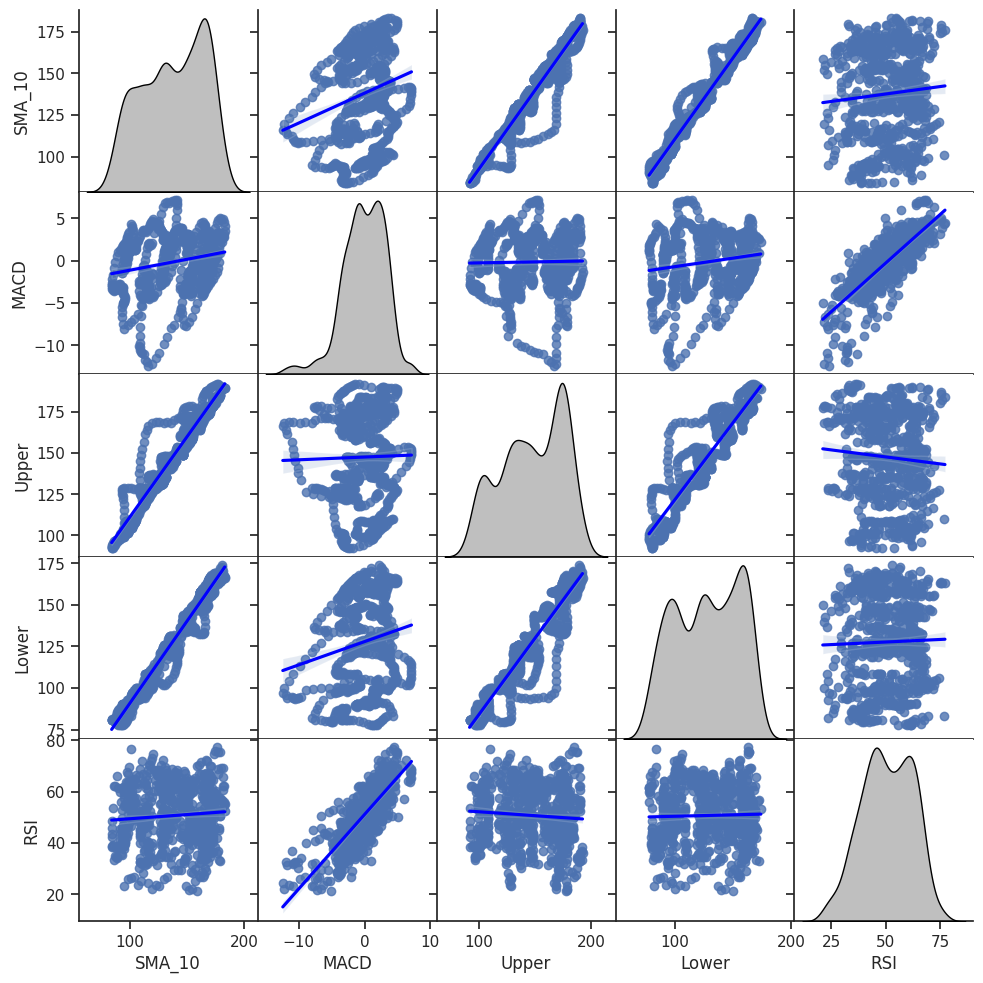

In [ ]:
# Create a pairplot with regression lines on the scatter plots and line plots on the diagonal
pair_plot = sns.pairplot(df[['SMA_10', 'MACD', 'Upper', 'Lower', 'RSI']], diag_kind='kde', kind='reg', markers='o', height=2, diag_kws={'color': 'black'})

# Set different colors for scatter plots and line plots
for i in range(pair_plot.axes.shape[0]):
    for j in range(pair_plot.axes.shape[1]):
        ax = pair_plot.axes[i, j]
        # Check if the axis has lines associated with it
        if ax.get_lines():
            if i != j:  # Scatter plots
                ax.get_lines()[0].set_color('blue')  # Set color for scatter plot
            else:  # Diagonal KDE plots
                ax.get_lines()[0].set_color('red')   # Set color for line plot

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()


In [ ]:
df[['SMA_10','MACD','Upper','Lower','RSI']].corr()

,SMA_10,MACD,Upper,Lower,RSI
SMA_10,1.000000,0.215306,0.963838,0.980020,0.076485
MACD,0.215306,1.000000,0.019969,0.167978,0.815540
Upper,0.963838,0.019969,1.000000,0.929926,-0.072140
Lower,0.980020,0.167978,0.929926,1.000000,0.026275
RSI,0.076485,0.815540,-0.072140,0.026275,1.000000


# Creating Actual Target

In [ ]:
lst = []
for i in range(0, len(df) - 11):
  lst.append(df['Adj Close'][i:i+10].sum()/10)
for i in range(len(df)-11,len(df)):
  lst.append(None)

df['Next_10_Days_Mean'] = lst
# Create a new column 'Target' based on the comparison of today's Close with the next 10 days' mean
df['Target'] = np.where(df['Next_10_Days_Mean'] - df['Adj Close']  > 0, 'Long', 'Short')


Short - 0 / Long - 1

In [ ]:
custom_mapping = {'Short': 0, 'Long': 1}

# Use a list comprehension to map the labels
df['Target'] = [custom_mapping[label] for label in df['Target']]

df.dropna(inplace=True)

In [ ]:
df.head(5)

,Adj Close,SMA_10,MACD,Upper,Lower,RSI,Next_10_Days_Mean,Target
Date,,,,,,,,
2021-02-23,159.725006,163.311900,-1.126245,169.653311,158.878738,37.187995,153.398851,0
2021-02-24,157.976501,162.584550,-1.459822,169.799976,157.899073,33.921645,152.740601,0
2021-02-25,152.858002,161.437451,-2.112850,171.014602,155.807348,26.565655,152.231151,0
2021-02-26,154.646500,160.591451,-2.457731,171.545531,154.552969,32.105873,152.513301,0
2021-03-01,157.307007,159.933601,-2.487694,171.684918,154.113283,39.426841,152.496101,0


# Visualizing Actual Target distribution

In [ ]:
fig = px.scatter(df, x='MACD', y='Upper', color='Target', labels={'MACD': 'MACD', 'Upper': 'Upper'},
                 color_discrete_map={0: 'blue', 1: 'orange'}, title='Scatter Plot of MACD and Upper with Target')

fig.show()


# Normalizing data

In [ ]:
# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the scaler on the data and transform the data
df.iloc[:,:-1] = scaler.fit_transform(df.iloc[:,:-1])

In [ ]:
df.head(5)

,Adj Close,SMA_10,MACD,Upper,Lower,RSI,Next_10_Days_Mean,Target
Date,,,,,,,,
2021-02-23,0.818494,0.953805,-0.291038,0.804607,1.148592,-1.148143,0.595011,0
2021-02-24,0.754841,0.927103,-0.392320,0.809916,1.112824,-1.429031,0.570785,0
2021-02-25,0.568509,0.884992,-0.590592,0.853888,1.036454,-2.061605,0.552036,0
2021-02-26,0.633617,0.853934,-0.695305,0.873109,0.990656,-1.585177,0.562420,0
2021-03-01,0.730469,0.829784,-0.704403,0.878155,0.974603,-0.955615,0.561787,0


# Calculating weights for Combined Indicators using initial indicators

In [ ]:
X =np.array( df[['SMA_10','MACD','Upper','Lower','RSI']])
X_train, X_test, y_train, y_test = train_test_split(X, df['Target'], test_size=0.2, random_state=42)
A = np.column_stack((X_train, np.ones((len(X_train), 1), dtype=float)))

corr = np.dot(A.T, A)/(len(A)-1)
weights = np.dot(np.linalg.inv(corr), np.dot(A.T, y_train))

print(weights)


[-62.67547482   1.18131979 -76.33275781  85.7537673  -22.49166616
 300.86569685]


# Prediction

In [ ]:
X_test = np.column_stack((X_test, np.ones((len(X_test), 1), dtype=float)))
output = X_test@weights

min(output), max(output), mean(output)

(157.76368977065368, 437.9941411353444, 302.4043463322317)

In [ ]:
y_pred = np.where(output >= mean(output), 1, 0)

# Accuracy and F1 Score

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(y_pred, y_test)

# Display the accuracy
print("Accuracy:", accuracy)


# Assuming y_true contains the true labels and y_pred contains the predicted labels
# For binary classification
f1_binary = f1_score(y_test, y_pred, average='binary')

print(f'F1 score (binary): {f1_binary}')



Accuracy: 0.5448275862068965
F1 score (binary): 0.5540540540540541


# Confusion Matrix

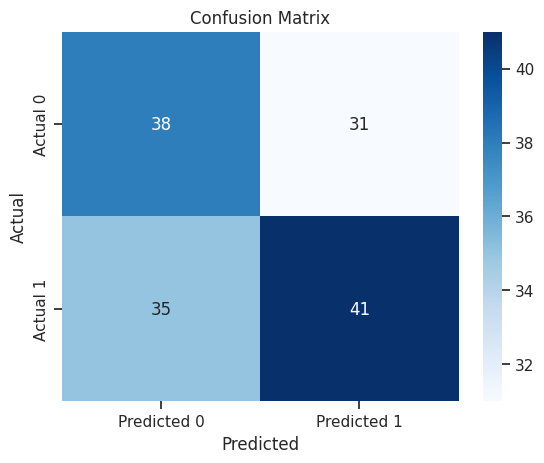

In [ ]:
# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
